## **Import Libraries**

In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

## **Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset"
#TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset/train/'
#TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset/test'
train_data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/train/'
filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
df

,filepaths,label
0,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
1,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
2,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
3,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
4,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
...,...,...
7753,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia
7754,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia
7755,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia
7756,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia


In [ ]:
test_data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/test/'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test = pd.concat([Fseries , Lseries] , axis = 1)
test

,filepaths,label
0,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
1,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
2,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
3,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
4,/content/drive/MyDrive/Colab Notebooks/dataset...,NoOsteoarthritis
...,...,...
962,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia
963,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia
964,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia
965,/content/drive/MyDrive/Colab Notebooks/dataset...,Pneumonia


In [ ]:
valid_data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/test/'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
valid = pd.concat([Fseries , Lseries] , axis = 1)
valid

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/dataset/valid/1G0_Z9.jpg'

In [ ]:
fig= px.histogram(data_frame= df,
           y= df['label'],
           template='plotly_dark',
           color= df['label'].values,
           title='number of images in each class of the train data')
fig.show()

In [ ]:
fig= px.histogram(data_frame= test,
           y= test['label'],
           template='plotly_dark',
           color=test['label'].values,
           title='number of images in each class of the test data')
fig.show()

In [ ]:
fig= px.histogram(data_frame= valid,
           y= valid['label'],
           template='plotly_dark',
           color=valid['label'].values,
           title='number of images in each class of the valid data')
fig.show()

### All the images in class pneumonia in greater than class normal in the train, test and validation data frames

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle= True, random_state= 42)
valid_df, test_df= train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= 42)

## **Image Data Generator**

In [ ]:
img_size = (224 ,224)
batch_size = 16
img_shape= (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 6206 validated image filenames belonging to 4 classes.
Found 931 validated image filenames belonging to 4 classes.
Found 621 validated image filenames belonging to 4 classes.


## **Show Sample from the train data**

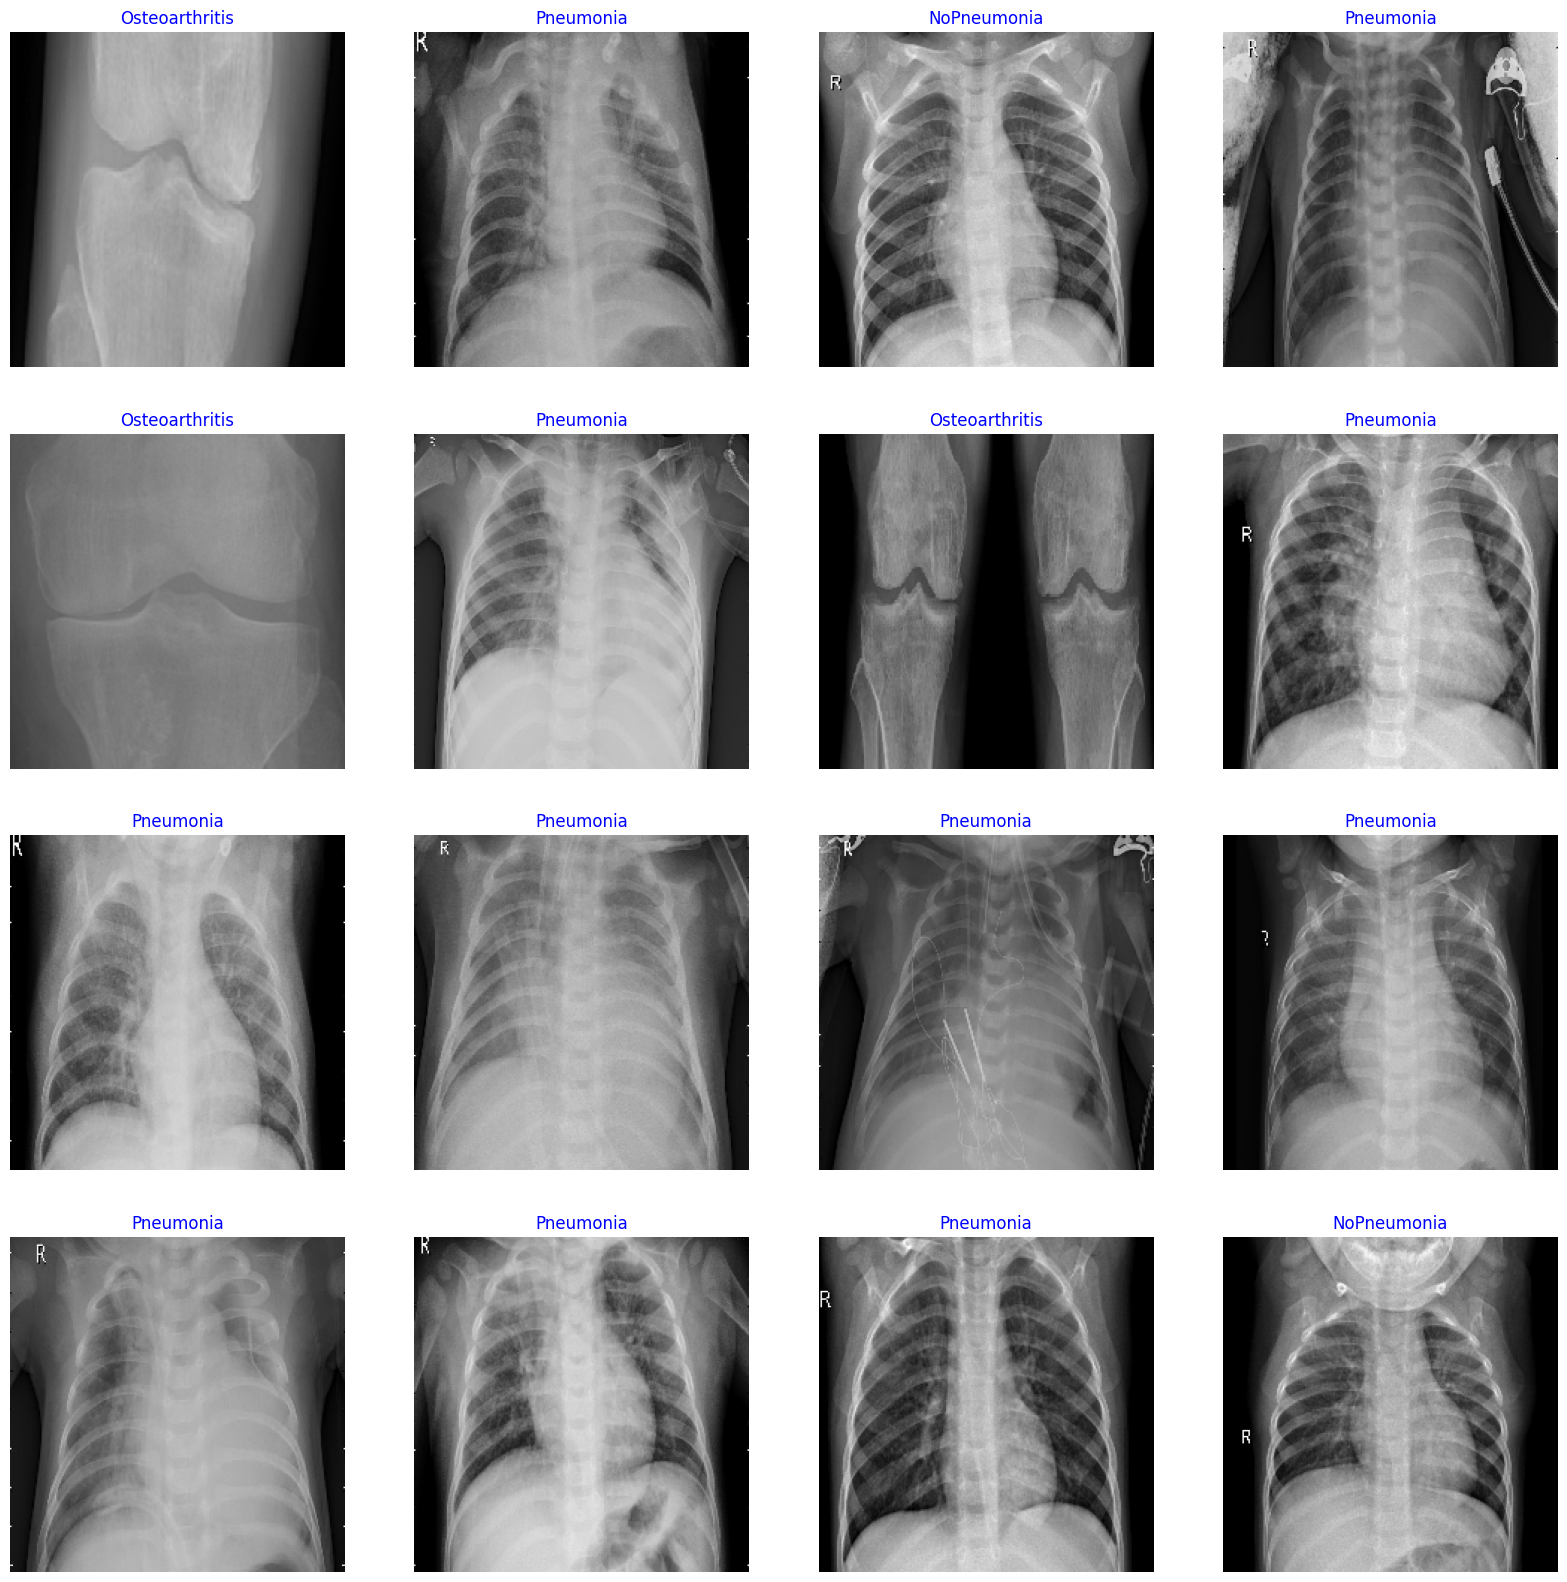

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## **Model Structure**

In [ ]:
img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])
model.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 1109

## **Model Training**

In [ ]:
import os

In [ ]:
Epochs = 20
save_dir = 'saved'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#if os.path.exists(f'{save_dir}/best_model_weights.h5'):
# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(f'{save_dir}/best_model_weights.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(x= train_gen , epochs = Epochs, verbose = 1, validation_data= valid_gen,validation_steps = None , shuffle = False, callbacks=[checkpoint])

Epoch 1/20
388/388 [==============================] - 121s 310ms/step - loss: 2.2189 - accuracy: 0.9821 - val_loss: 2.1110 - val_accuracy: 0.9506
Epoch 2/20
388/388 [==============================] - 119s 305ms/step - loss: 1.9102 - accuracy: 0.9813 - val_loss: 1.8123 - val_accuracy: 0.9624
Epoch 3/20
388/388 [==============================] - 118s 304ms/step - loss: 1.6497 - accuracy: 0.9824 - val_loss: 1.5871 - val_accuracy: 0.9613
Epoch 4/20
388/388 [==============================] - 117s 300ms/step - loss: 1.4352 - accuracy: 0.9855 - val_loss: 1.3964 - val_accuracy: 0.9581
Epoch 5/20
388/388 [==============================] - 118s 302ms/step - loss: 1.2468 - accuracy: 0.9871 - val_loss: 1.2158 - val_accuracy: 0.9624
Epoch 6/20
388/388 [==============================] - 118s 304ms/step - loss: 1.0862 - accuracy: 0.9874 - val_loss: 1.0906 - val_accuracy: 0.9527
Epoch 7/20
388/388 [==============================] - 117s 301ms/step - loss: 0.9439 - accuracy: 0.9918 - val_loss: 0.9574 -

## **Evaluation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 트레인 데이터 augmentation 의로 데이터를 증가 시킴니다.
# 각 이미지의 기본 주소
BASE_PATH = './drive/MyDrive/Colab Notebooks/data/'

train_datagen = ImageDataGenerator(rotation_range=30,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

train_set = train_datagen.flow_from_directory(BASE_PATH + 'train/',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode='categorical')



In [ ]:
# 학습을 완료후에 모델 성능 테스트에 사용할 데이터셋 입니다.

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(BASE_PATH + 'test/',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode='categorical')

In [ ]:
import pickle

# key 와 value 값을 바꾸어 줍니다.
class4 = dict()
for key,value in test_set.class_indices.items():
    class4[value] = key

with open(BASE_PATH+'bin/class4.pickle', 'wb') as f:
    pickle.dump(class4, f)

In [ ]:
class4

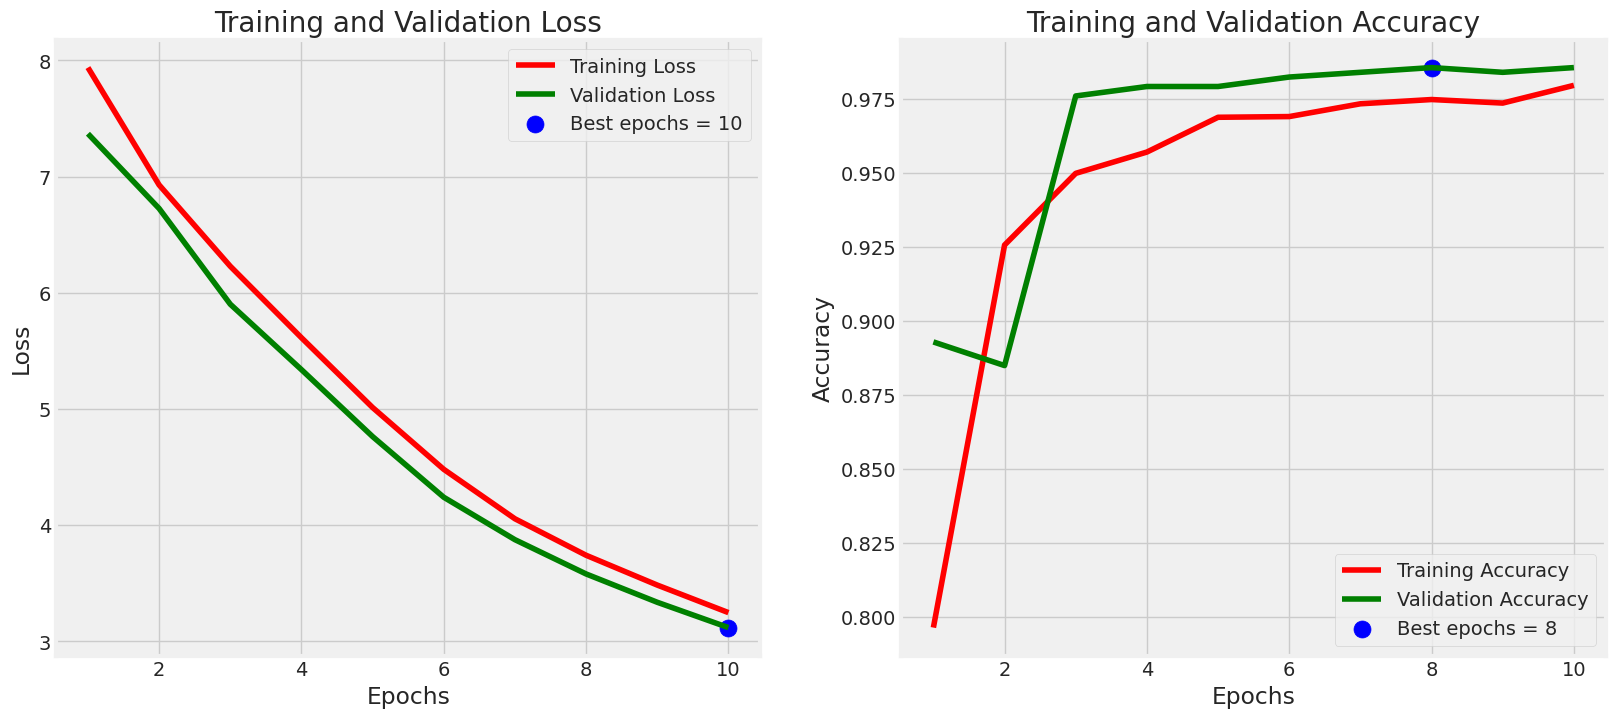

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
#test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 4s 245ms/step - loss: 3.1012 - accuracy: 0.9961
Train Loss:  3.089794635772705
Train Accuracy:  0.99609375
--------------------
Validation Loss:  3.1279563903808594
Validation Accuracy:  0.98046875
--------------------
Test Loss:  3.101221799850464
Test Accuracy:  0.99609375


## **Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

## **Confusion matrix and Classification report**

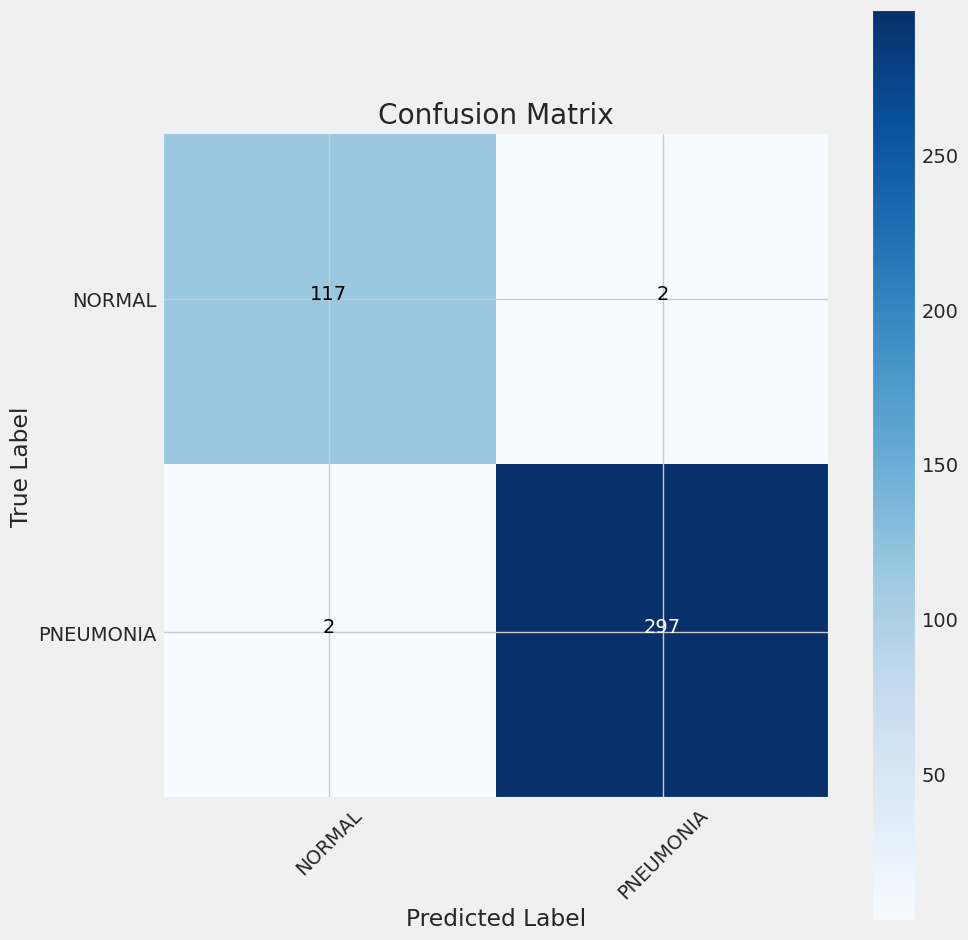

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98       119
   PNEUMONIA       0.99      0.99      0.99       299

    accuracy                           0.99       418
   macro avg       0.99      0.99      0.99       418
weighted avg       0.99      0.99      0.99       418

